<a href="https://colab.research.google.com/github/jcorner1/MMH_Project/blob/main/SAM2_Model_stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use Segemment Anything 2 Model
This notebook is developed from a few resources:


* https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-videos-with-sam-2.ipynb?ref=blog.roboflow.com#scrollTo=U1V7_00F9Yn3
* https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb
* https://github.com/facebookresearch/segment-anything-2







In [1]:
!nvidia-smi

Thu Aug  8 18:53:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [3]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [4]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.4 MB/s eta 0:00:00


In [5]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [6]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [7]:
!mkdir -p {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

In [8]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [9]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [10]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [11]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import os

IMAGE_NAME = "/content/drive/My Drive/Colab Notebooks/Sat_Images/mobile_home_image.png"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [13]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [14]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


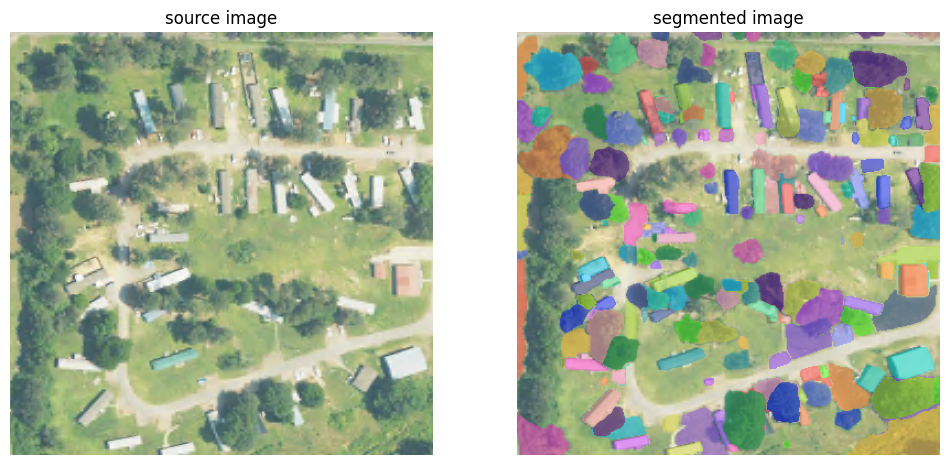

In [15]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

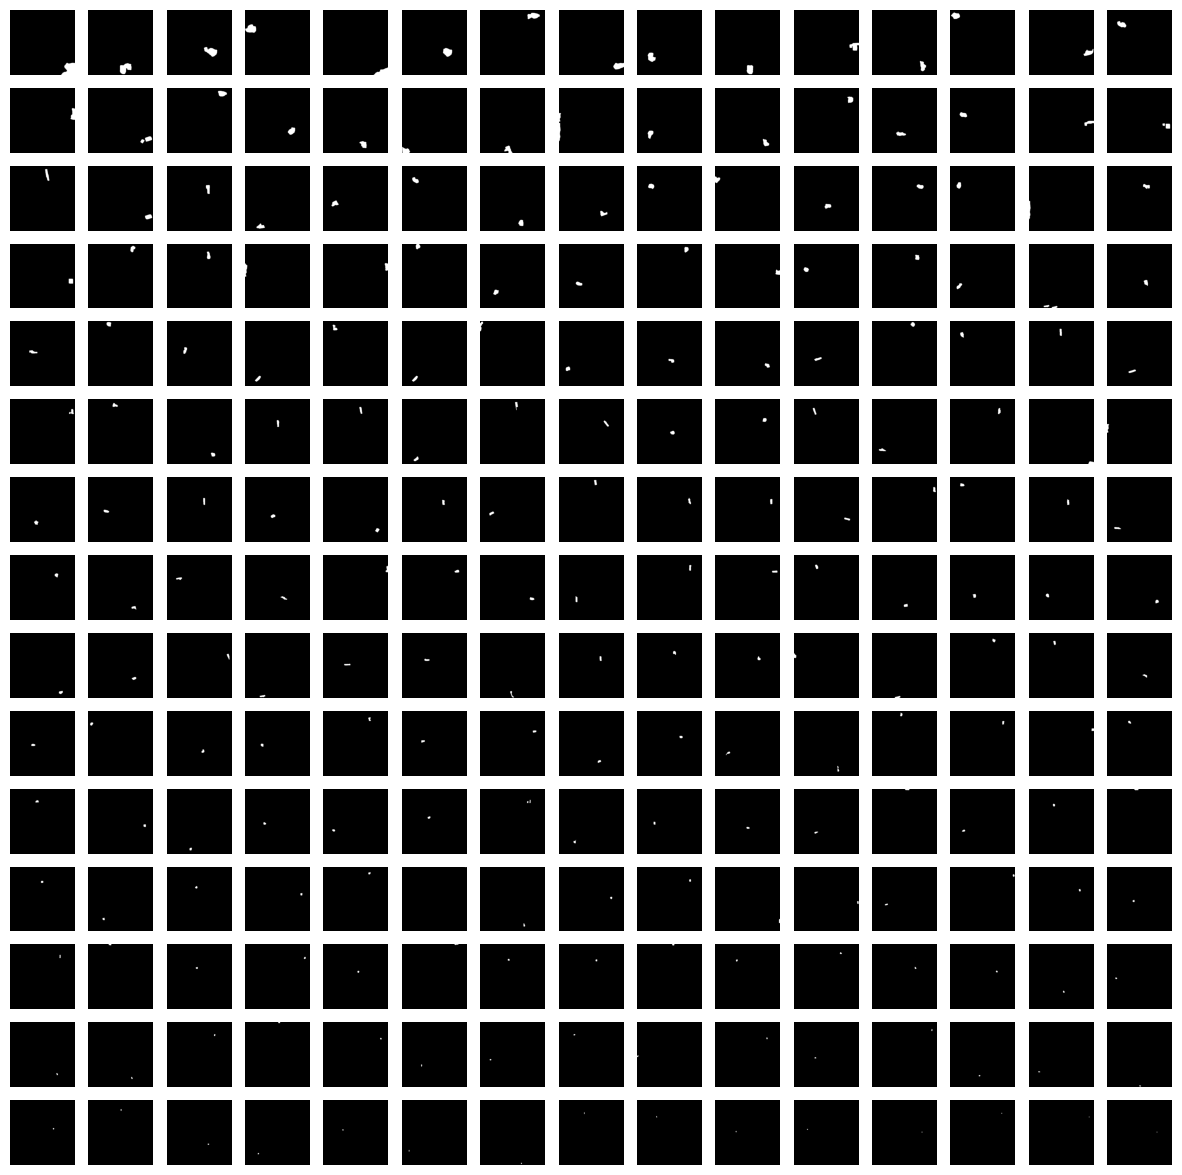

In [16]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(15, int(len(masks) / 15)),
    size=(15, 15)
)

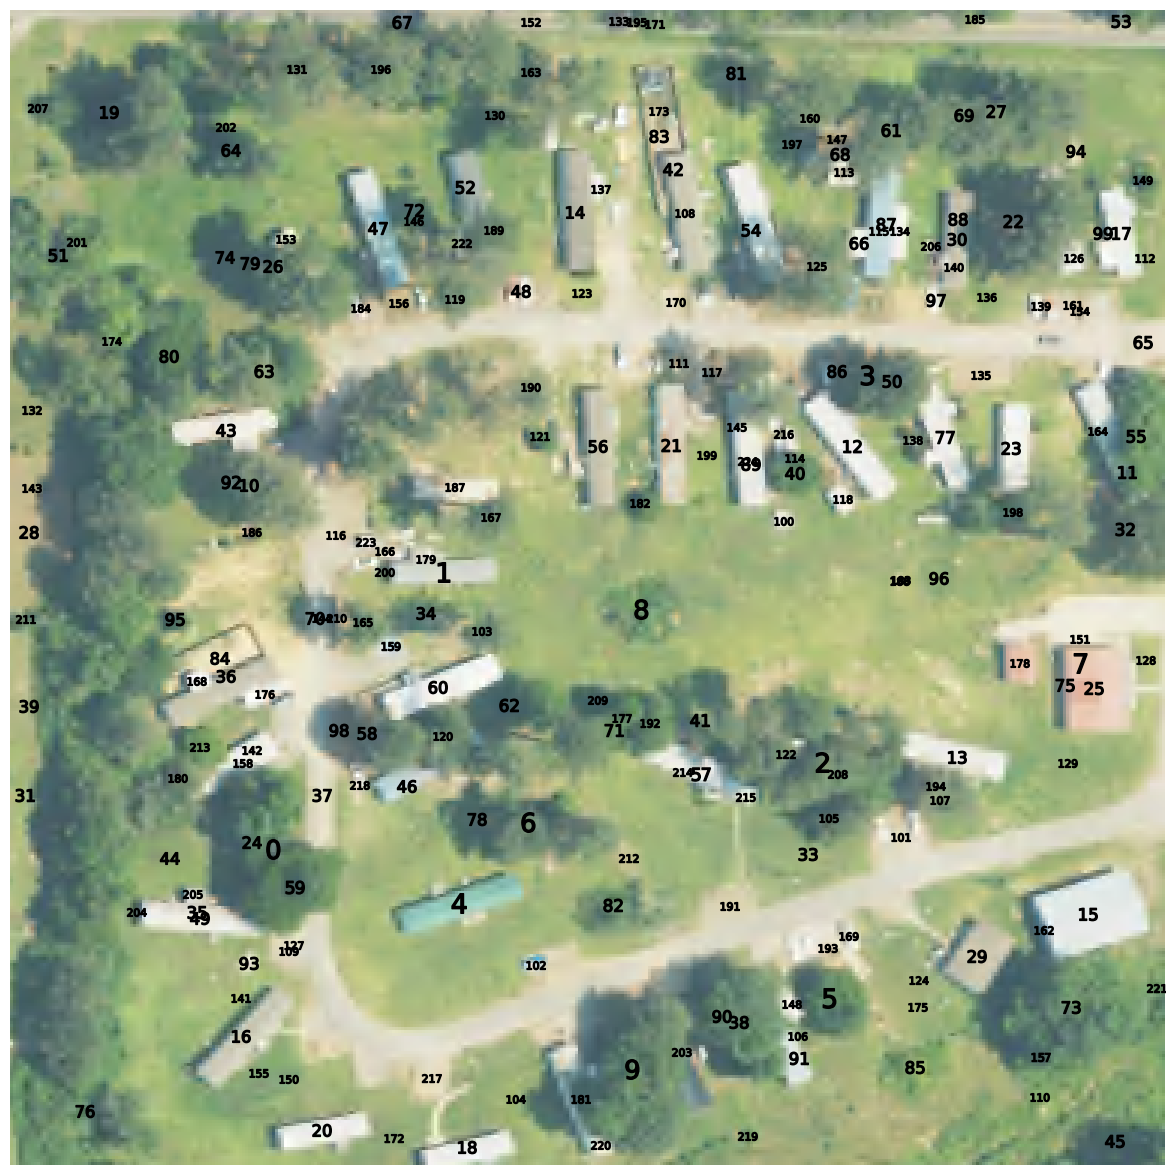

In [45]:
# prompt: place points using sam_results as x and ys

# Extract x and y coordinates from sam_results
x_coords = [(result['bbox'][0]+(result['bbox'][0]+result['bbox'][2]))/2 for result in sam_result]
y_coords = [(result['bbox'][1]+(result['bbox'][1]+result['bbox'][3]))/2 for result in sam_result]

# Plot the image with points
plt.figure(figsize=(20, 15))  # Adjust the figure size here
plt.imshow(image_rgb)
for z in range(len(x_coords)):
  plt.scatter(x_coords[z], y_coords[z], color='k', marker= f'${z}$', s=200)
plt.axis('off')
plt.show()


## Masking out Single Objects

In [17]:
sam_result[78]['bbox']

[142, 256, 25, 25]

In [18]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 142, 'y': 256, 'width': 25, 'height': 25, 'label': ''}

box = default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [19]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
mask_predictor = SamPredictor(sam)

mask_predictor.set_image(image_rgb)

new_masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

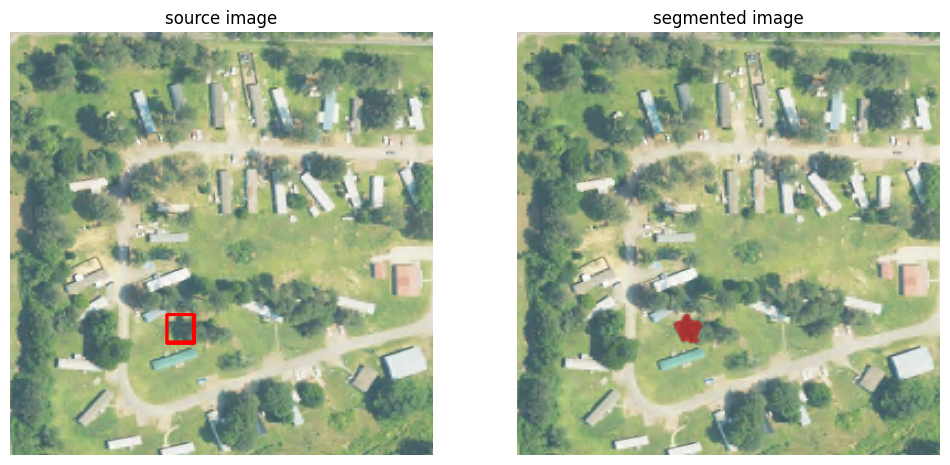

In [20]:
box_annotator = sv.BoxAnnotator(color=sv.Color(255, 0, 0))
mask_annotator = sv.MaskAnnotator(color=sv.Color(255, 0, 0), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=new_masks),
    mask=new_masks
)
#detections = detections[detections.area == np.max(detections.area)]
detections.class_id = 'Home'

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [21]:
def model_pred(box):

  # convert information and append to np array
  box = np.array([
      box[0],
      box[1],
      box[0] + box[2],
      box[1] + box[3]
  ])

  #
  image_bgr = cv2.imread(IMAGE_PATH)
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  mask_predictor = SamPredictor(sam)

  mask_predictor.set_image(image_rgb)

  masks, scores, logits = mask_predictor.predict(
      box=box,
      multimask_output=True
  )

  #
  box_annotator = sv.BoxAnnotator(color=sv.Color(255, 0, 0))
  mask_annotator = sv.MaskAnnotator(color=sv.Color(255, 0, 0), color_lookup=sv.ColorLookup.INDEX)

  detections = sv.Detections(
      xyxy=sv.mask_to_xyxy(masks=masks),
      mask=masks
  )
  #detections = detections[detections.area == np.max(detections.area)]
  detections.class_id = 'Home'

  source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
  segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

  return source_image, segmented_image

In [22]:
# current mask to look through
i = 224

# set current mask as box
box = sam_result[i]['bbox']
box

[237, 135, 15, 29]

The current image is mask number 224


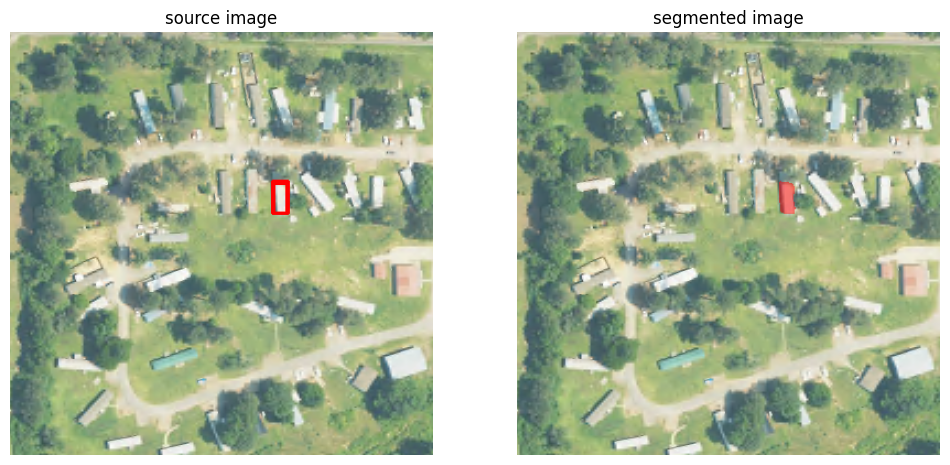

In [23]:
source_image, segmented_image = model_pred(box)
print(f'The current image is mask number {i}')

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)


In [48]:
# lists of mobile homes and possible homes
poss_mob_homes = [11, 17, 36, 42, 46, 52, 54, 57, 91, 106, 145, 172, 179, 224]
mobile_homes = [1, 4, 12, 13, 14, 16, 18, 20, 21, 23, 30, 43, 47, 49, 56, 60, 77, 89, 99, 108, 164, 181, 187, 214, 36]

# prompt: subset the masks variable based on the list mobile_homes
new_results = [sam_result[i] for i in mobile_homes]


## Mobile Home Results

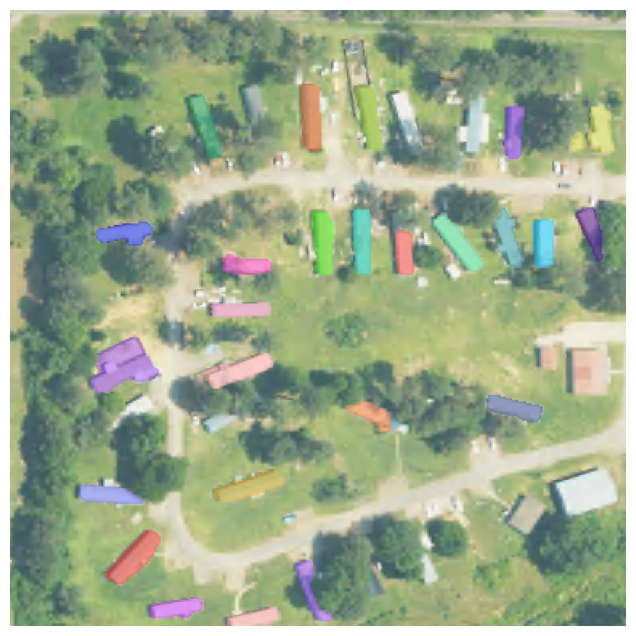

In [49]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=new_results)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_image(annotated_image, size=(8, 8))

## Possible Mobile Home Results

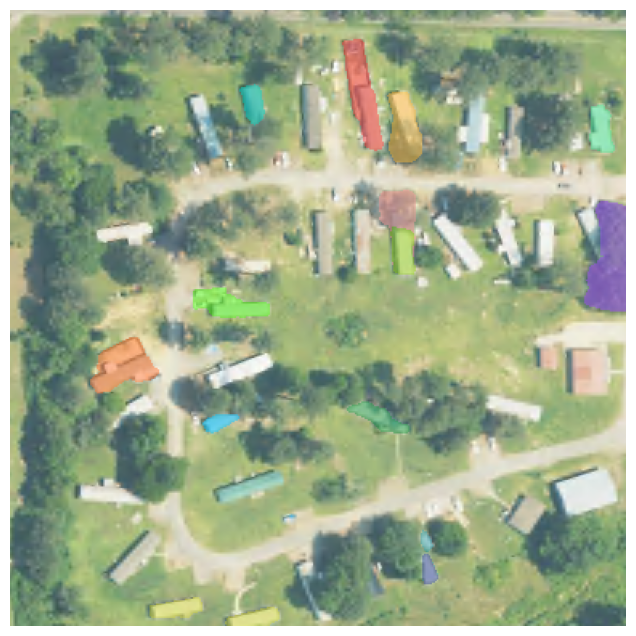

In [50]:
#
poss_results = [sam_result[i] for i in poss_mob_homes]


#
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(text_position=sv.Position.CENTER)

detections = sv.Detections.from_sam(sam_result=poss_results)
detections.class_id = poss_mob_homes

#for j, num in enumerate(poss_mob_homes):
  #detections[j].class_id = num

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
#annotated_image = label_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_image(annotated_image, size=(8, 8))